In [1]:
#import useful libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt

In [116]:
#load cleaned football data and begin clustering process for group 1 and group 2
ft_data = pd.read_csv("cleaned_football.csv")

C:\Users\a\AppData\Local\Temp\ipykernel_19240\2302574395.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  ft_data = pd.read_csv("cleaned_football.csv")


In [117]:
#Due to limited data from some competitions, the data has been limited to the leagues captures in the competition name argument

new_data = ft_data[ft_data["competition_name"].isin(["FA Women's Super League", "Women's World Cup", "Champions League",
                                  'La Liga', 'Indian Super league','FIFA World Cup','UEFA Euro'])]
new_data = new_data.reset_index(drop=True)

In [118]:
#To maintain data quality and consistency in the data gathering techniques, the most recent competiotn or season from 2010
#has been used for training and testing.

final_data = new_data[new_data["season_name"].isin(['2017/2018', '2016/2017' '2010/2011', '2011/2012',
       '2012/2013', '2013/2014', '2014/2015', '2015/2016','2018/2019',
       '2019/2020', '2020/2021', '2021/2022', '2022', '2018',
       '2020', '2019'])].reset_index(drop=True)

In [119]:
#The shots have been limited to just freekick shots and open play shots. Penalties and coner kick shots are excluded.
pk_cr_drop = final_data[final_data["shot_type"].isin(["Open Play", "Free Kick"])]

data_1 = pk_cr_drop.reset_index(drop=True)

In [120]:
data_1

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,play_pattern_name,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defence_density,x_list,y_list
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,From Throw In,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,26.658770,12.341965,2.0,101.0,21.3
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,From Free Kick,Valencia,Santiago Mina Lorenzo,Left Center Forward,Normal,19.843639,18.826717,1.0,103.9,28.4
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,From Throw In,Barcelona,Jordi Alba Ramos,Left Back,Normal,15.882380,14.250033,1.0,112.5,26.0
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,From Throw In,Barcelona,Luis Alberto Suárez Díaz,Left Center Forward,Normal,9.068627,39.394758,1.0,113.2,46.0
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Regular Play,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,28.111386,15.697815,2.0,92.8,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24029,22924,2019-06-08,72,30,"[102.6, 35.5]",False,0.117915,"[118.6, 40.3, 0.2]",No Goal,Open Play,...,Regular Play,Norway Women's,Elise Thorsnes,Left Center Forward,Normal,17.972479,24.389797,2.0,102.6,35.5
24030,22924,2019-06-08,72,30,"[106.6, 37.2]",False,0.074454,"[118.0, 39.7, 0.3]",No Goal,Open Play,...,From Keeper,Norway Women's,Caroline Graham Hansen,Right Midfield,Normal,13.689412,32.023408,1.0,106.6,37.2
24031,22924,2019-06-08,72,30,"[92.7, 31.6]",False,0.051410,"[120.0, 42.7, 5.3]",No Goal,Free Kick,...,From Free Kick,Norway Women's,Caroline Graham Hansen,Right Midfield,Normal,28.563088,15.272392,3.0,92.7,31.6
24032,22924,2019-06-08,72,30,"[95.7, 38.9]",False,0.054328,"[120.0, 31.3, 0.0]",No Goal,Open Play,...,From Throw In,Nigeria Women's,Francisca Ordega,Right Wing,Normal,24.324884,18.658585,1.0,95.7,38.9


In [121]:
gk_index = list(data_1[data_1['position_name'] == 'Goalkeeper'].index)
data_1.drop(gk_index, inplace=True)

In [122]:
data_1.reset_index(drop=True, inplace=True)

In [123]:
cluster_1 = data_1[['shot_outcome', 'shot_type','body_part','shot_distance','shot_angle', 'season_name', 'competition_name', 'stats_xg']]
cluster_2 = data_1[['under_pressure', 'shot_outcome', 'shot_type', 'body_part', 'shot_technique', 'position_name',
                    'shot_distance','shot_angle', 'defence_density', 'season_name', 'competition_name', 'stats_xg']]

In [124]:
cluster_1[cluster_1["competition_name"].isin(["La Liga"])
         ][cluster_1[cluster_1["competition_name"].isin(["La Liga"])
                    ]["season_name"].isin(['2017/2018', '2016/2017','2010/2011', '2011/2012',
                                           '2012/2013', '2013/2014', '2014/2015', '2015/2016', 
                                           '2018/2019','2019/2020', '2020/2021'])]

,shot_outcome,shot_type,body_part,shot_distance,shot_angle,season_name,competition_name,stats_xg
0,No Goal,Open Play,Right Foot,26.658770,12.341965,2017/2018,La Liga,0.008752
1,No Goal,Open Play,Right Foot,19.843639,18.826717,2017/2018,La Liga,0.053915
2,No Goal,Open Play,Left Foot,15.882380,14.250033,2017/2018,La Liga,0.080842
3,Goal,Open Play,Right Foot,9.068627,39.394758,2017/2018,La Liga,0.456472
4,No Goal,Open Play,Right Foot,28.111386,15.697815,2017/2018,La Liga,0.025283
...,...,...,...,...,...,...,...,...
7508,No Goal,Open Play,Head,12.628935,34.873129,2020/2021,La Liga,0.035400
7509,No Goal,Open Play,Right Foot,12.525574,25.764096,2020/2021,La Liga,0.098630
7510,Goal,Open Play,Left Foot,8.570298,33.759057,2020/2021,La Liga,0.365302
7511,No Goal,Open Play,Right Foot,22.908514,18.110023,2020/2021,La Liga,0.032844


In [125]:
cluster_2["shot_angle"].max()

180.0

In [126]:
cluster_2.isnull().sum()
cluster_1.isnull().sum()

shot_outcome        0
shot_type           0
body_part           0
shot_distance       0
shot_angle          3
season_name         0
competition_name    0
stats_xg            0
dtype: int64

In [127]:
cluster_1.dropna(inplace=True)
cluster_2.dropna(inplace=True)

C:\Users\a\AppData\Local\Temp\ipykernel_19240\45521486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1.dropna(inplace=True)
C:\Users\a\AppData\Local\Temp\ipykernel_19240\45521486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2.dropna(inplace=True)


In [128]:
cluster_1.reset_index(drop=True)
cluster_2.reset_index(drop=True)

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defence_density,season_name,competition_name,stats_xg
0,False,No Goal,Open Play,Right Foot,Normal,Left Midfield,26.658770,12.341965,2.0,2017/2018,La Liga,0.008752
1,False,No Goal,Open Play,Right Foot,Normal,Left Center Forward,19.843639,18.826717,1.0,2017/2018,La Liga,0.053915
2,False,No Goal,Open Play,Left Foot,Normal,Left Back,15.882380,14.250033,1.0,2017/2018,La Liga,0.080842
3,False,Goal,Open Play,Right Foot,Normal,Left Center Forward,9.068627,39.394758,1.0,2017/2018,La Liga,0.456472
4,False,No Goal,Open Play,Right Foot,Normal,Left Midfield,28.111386,15.697815,2.0,2017/2018,La Liga,0.025283
...,...,...,...,...,...,...,...,...,...,...,...,...
24024,False,No Goal,Open Play,Right Foot,Normal,Left Center Forward,17.972479,24.389797,2.0,2019,Women's World Cup,0.117915
24025,False,No Goal,Open Play,Right Foot,Normal,Right Midfield,13.689412,32.023408,1.0,2019,Women's World Cup,0.074454
24026,False,No Goal,Free Kick,Right Foot,Normal,Right Midfield,28.563088,15.272392,3.0,2019,Women's World Cup,0.051410
24027,False,No Goal,Open Play,Right Foot,Normal,Right Wing,24.324884,18.658585,1.0,2019,Women's World Cup,0.054328


In [129]:
def categorize_position(position):
    if 'Forward' in position or 'Attacking Midfield' in position or 'Secondary Striker' in position or 'Left Wing' in position or 'Right Wing' in position:
        return 'attacker'
    elif 'Midfield' in position:
        return 'midfielder'
    elif 'Back' in position:
        return 'defender'
    else:
        return 'unknown'

In [130]:
def correct_lwback(position):
    if 'Right Wing Back' in position:
        return 'RW Back'
    elif 'Left Wing Back' in position:
        return 'LW Back'
    else:
        return position

In [131]:
cluster_2["position_name"] = cluster_2["position_name"].apply(correct_lwback)

C:\Users\a\AppData\Local\Temp\ipykernel_19240\3475892885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2["position_name"] = cluster_2["position_name"].apply(correct_lwback)


In [132]:
cluster_2["position_name"] = cluster_2["position_name"].apply(categorize_position)

C:\Users\a\AppData\Local\Temp\ipykernel_19240\3130435758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2["position_name"] = cluster_2["position_name"].apply(categorize_position)


In [133]:
cluster_2["position_name"].unique()

array(['midfielder', 'attacker', 'defender'], dtype=object)

In [134]:
cluster_1[cluster_1["competition_name"].isin(["La Liga"])
         ][cluster_1[cluster_1["competition_name"].isin(["La Liga"])
                    ]["season_name"].isin(['2017/2018', '2016/2017','2010/2011', '2011/2012',
                                           '2012/2013', '2013/2014', '2014/2015', '2015/2016', 
                                           '2018/2019','2019/2020', '2020/2021'])]

,shot_outcome,shot_type,body_part,shot_distance,shot_angle,season_name,competition_name,stats_xg
0,No Goal,Open Play,Right Foot,26.658770,12.341965,2017/2018,La Liga,0.008752
1,No Goal,Open Play,Right Foot,19.843639,18.826717,2017/2018,La Liga,0.053915
2,No Goal,Open Play,Left Foot,15.882380,14.250033,2017/2018,La Liga,0.080842
3,Goal,Open Play,Right Foot,9.068627,39.394758,2017/2018,La Liga,0.456472
4,No Goal,Open Play,Right Foot,28.111386,15.697815,2017/2018,La Liga,0.025283
...,...,...,...,...,...,...,...,...
7508,No Goal,Open Play,Head,12.628935,34.873129,2020/2021,La Liga,0.035400
7509,No Goal,Open Play,Right Foot,12.525574,25.764096,2020/2021,La Liga,0.098630
7510,Goal,Open Play,Left Foot,8.570298,33.759057,2020/2021,La Liga,0.365302
7511,No Goal,Open Play,Right Foot,22.908514,18.110023,2020/2021,La Liga,0.032844


In [135]:
cluster_1[cluster_1["competition_name"].isin(["FA Women's Super League", "Women's World Cup", "Champions League"])]

,shot_outcome,shot_type,body_part,shot_distance,shot_angle,season_name,competition_name,stats_xg
10563,No Goal,Open Play,Right Foot,25.020392,16.024261,2017/2018,Champions League,0.036399
10564,No Goal,Open Play,Left Foot,26.073166,15.748898,2017/2018,Champions League,0.027976
10565,No Goal,Open Play,Head,12.278844,25.124093,2017/2018,Champions League,0.075361
10566,No Goal,Open Play,Left Foot,28.668101,14.205751,2017/2018,Champions League,0.023376
10567,No Goal,Open Play,Left Foot,21.019039,19.454111,2017/2018,Champions League,0.043772
...,...,...,...,...,...,...,...,...
24027,No Goal,Open Play,Right Foot,17.972479,24.389797,2019,Women's World Cup,0.117915
24028,No Goal,Open Play,Right Foot,13.689412,32.023408,2019,Women's World Cup,0.074454
24029,No Goal,Free Kick,Right Foot,28.563088,15.272392,2019,Women's World Cup,0.051410
24030,No Goal,Open Play,Right Foot,24.324884,18.658585,2019,Women's World Cup,0.054328


From the above, La Liga football information gathered by the Statsbomb stopped at 2020/2021 season. The 2020/2021 season contains 839 shot instances. The Fifa world cup 2022 is combined with the 2021 laliga football and used to validate the model.

In [136]:
Counter(cluster_1["competition_name"])

Counter({'La Liga': 7512,
         'Indian Super league': 3050,
         'Champions League': 240,
         "FA Women's Super League": 8234,
         'FIFA World Cup': 3065,
         'UEFA Euro': 1234,
         "Women's World Cup": 694})

In [137]:
val_data = cluster_1[cluster_1["competition_name"].isin(["La Liga", "FA Women's Super League", "FIFA World Cup"])]
val_data = val_data[val_data["season_name"].isin(["2020/2021", "2022", "2019"])]

Drop the corresponding index value from the cluster_1 data to create the training and test data.


In [138]:
clus_1_index = val_data.index
print(clus_1_index)

Int64Index([ 6687,  6688,  6689,  6690,  6691,  6692,  6693,  6694,  6695,
             6696,
            ...
            20457, 20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465,
            20466],
           dtype='int64', length=5464)


In [139]:
#drop index numbers from cluster_1
cluster_1_data = cluster_1.drop(clus_1_index)
cluster_1_data.reset_index(drop=True, inplace=True)

In [140]:
val_data_2 = cluster_2[cluster_2["competition_name"].isin(["La Liga", "FA Women's Super League", "FIFA World Cup"])]
val_data_2 = val_data_2[val_data_2["season_name"].isin(["2020/2021", "2022", "2019"])]

In [141]:
clus_2_index = val_data_2.index

In [142]:
#drop index numbers from cluster_2
cluster_2_data = cluster_2.drop(clus_2_index)
cluster_2_data.reset_index(drop=True, inplace=True)

In [143]:
cluster_1_data.isnull().sum()

shot_outcome        0
shot_type           0
body_part           0
shot_distance       0
shot_angle          0
season_name         0
competition_name    0
stats_xg            0
dtype: int64

In [144]:
cluster_2_data.isnull().sum()

under_pressure      0
shot_outcome        0
shot_type           0
body_part           0
shot_technique      0
position_name       0
shot_distance       0
shot_angle          0
defence_density     0
season_name         0
competition_name    0
stats_xg            0
dtype: int64

In [145]:
cluster_2_data

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defence_density,season_name,competition_name,stats_xg
0,False,No Goal,Open Play,Right Foot,Normal,midfielder,26.658770,12.341965,2.0,2017/2018,La Liga,0.008752
1,False,No Goal,Open Play,Right Foot,Normal,attacker,19.843639,18.826717,1.0,2017/2018,La Liga,0.053915
2,False,No Goal,Open Play,Left Foot,Normal,defender,15.882380,14.250033,1.0,2017/2018,La Liga,0.080842
3,False,Goal,Open Play,Right Foot,Normal,attacker,9.068627,39.394758,1.0,2017/2018,La Liga,0.456472
4,False,No Goal,Open Play,Right Foot,Normal,midfielder,28.111386,15.697815,2.0,2017/2018,La Liga,0.025283
...,...,...,...,...,...,...,...,...,...,...,...,...
18560,False,No Goal,Open Play,Right Foot,Normal,attacker,17.972479,24.389797,2.0,2019,Women's World Cup,0.117915
18561,False,No Goal,Open Play,Right Foot,Normal,midfielder,13.689412,32.023408,1.0,2019,Women's World Cup,0.074454
18562,False,No Goal,Free Kick,Right Foot,Normal,midfielder,28.563088,15.272392,3.0,2019,Women's World Cup,0.051410
18563,False,No Goal,Open Play,Right Foot,Normal,attacker,24.324884,18.658585,1.0,2019,Women's World Cup,0.054328


In [146]:
#Function to create the X and y features, encode and transform the categroical features and scale the X features
def get_x_y(data_name, cols, num_cols, cat_cols):
    #grab the independent features using the provided columns 
    X = data_name[cols]
    #Set the target variable
    y = data_name["shot_outcome"]
    #create dataframe of categorical features
    X_categ = X[cat_cols]
    #Create a dataframe of numerical features
    X_numerical = X[num_cols]
    
    #Transform the categorical features
    encode = OneHotEncoder(sparse=False, handle_unknown="ignore")
    encode.fit(X_categ)
    X_array = encode.transform(X_categ)

    #Create a new DataFrame combining the encoded categorical columns and the numerical columns
    encoded_train_data = pd.DataFrame(X_array, columns=encode.get_feature_names_out(cat_cols))
    encoded_train_data[X_numerical.columns] = X_numerical
    
    #Using a robust scaler, scale the independent features
    scale_data = RobustScaler()
    x = scale_data.fit_transform(encoded_train_data)
    
    return x, y, encoded_train_data

In [147]:
y_targ = {"No Goal":0, "Goal":1}

In [148]:
columns = ['shot_type','body_part','shot_distance','shot_angle']
categorical = columns[:2]
numerical = columns[2:]
X, y_raw, see_data = get_x_y(cluster_1_data, columns, numerical, categorical)

In [149]:
see_data

,shot_type_Free Kick,shot_type_Open Play,body_part_Head,body_part_Left Foot,body_part_Other,body_part_Right Foot,shot_distance,shot_angle
0,0.0,1.0,0.0,0.0,0.0,1.0,26.658770,12.341965
1,0.0,1.0,0.0,0.0,0.0,1.0,19.843639,18.826717
2,0.0,1.0,0.0,1.0,0.0,0.0,15.882380,14.250033
3,0.0,1.0,0.0,0.0,0.0,1.0,9.068627,39.394758
4,0.0,1.0,0.0,0.0,0.0,1.0,28.111386,15.697815
...,...,...,...,...,...,...,...,...
18560,0.0,1.0,0.0,0.0,0.0,1.0,17.972479,24.389797
18561,0.0,1.0,0.0,0.0,0.0,1.0,13.689412,32.023408
18562,1.0,0.0,0.0,0.0,0.0,1.0,28.563088,15.272392
18563,0.0,1.0,0.0,0.0,0.0,1.0,24.324884,18.658585


In [150]:
val_data

,shot_outcome,shot_type,body_part,shot_distance,shot_angle,season_name,competition_name,stats_xg
6687,No Goal,Open Play,Left Foot,21.284971,21.117849,2020/2021,La Liga,0.050982
6688,No Goal,Open Play,Left Foot,14.787157,29.786272,2020/2021,La Liga,0.090202
6689,No Goal,Open Play,Left Foot,9.284934,21.742291,2020/2021,La Liga,0.235028
6690,No Goal,Open Play,Right Foot,19.131388,15.337779,2020/2021,La Liga,0.059612
6691,No Goal,Open Play,Left Foot,24.845321,18.260682,2020/2021,La Liga,0.054610
...,...,...,...,...,...,...,...,...
20462,No Goal,Open Play,Head,4.295346,80.344221,2022,FIFA World Cup,0.568312
20463,No Goal,Open Play,Right Foot,23.577320,14.537291,2022,FIFA World Cup,0.028724
20464,No Goal,Open Play,Head,6.449806,60.255119,2022,FIFA World Cup,0.145394
20465,No Goal,Open Play,Right Foot,26.852188,15.837147,2022,FIFA World Cup,0.028684


In [151]:
val_data.reset_index(drop=True, inplace=True)

In [152]:
#Extract the dependent and independent features from the validation data.
val_x, val_y, see_data_v2 = get_x_y(val_data, columns, numerical, categorical)

In [153]:
val_data

,shot_outcome,shot_type,body_part,shot_distance,shot_angle,season_name,competition_name,stats_xg
0,No Goal,Open Play,Left Foot,21.284971,21.117849,2020/2021,La Liga,0.050982
1,No Goal,Open Play,Left Foot,14.787157,29.786272,2020/2021,La Liga,0.090202
2,No Goal,Open Play,Left Foot,9.284934,21.742291,2020/2021,La Liga,0.235028
3,No Goal,Open Play,Right Foot,19.131388,15.337779,2020/2021,La Liga,0.059612
4,No Goal,Open Play,Left Foot,24.845321,18.260682,2020/2021,La Liga,0.054610
...,...,...,...,...,...,...,...,...
5459,No Goal,Open Play,Head,4.295346,80.344221,2022,FIFA World Cup,0.568312
5460,No Goal,Open Play,Right Foot,23.577320,14.537291,2022,FIFA World Cup,0.028724
5461,No Goal,Open Play,Head,6.449806,60.255119,2022,FIFA World Cup,0.145394
5462,No Goal,Open Play,Right Foot,26.852188,15.837147,2022,FIFA World Cup,0.028684


In [154]:
y = y_raw.map(y_targ)

In [155]:
val_y = val_y.map(y_targ)

In [156]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [157]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.62656978, -0.46491653],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.11465682, -0.05388367],
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
        -0.18288987, -0.34397459],
       ...,
       [ 1.        , -1.        ,  0.        , ...,  0.        ,
         0.76961109, -0.27917285],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.4512619 , -0.06454068],
       [ 0.        ,  0.        ,  1.        , ..., -1.        ,
        -0.09151721,  0.40509176]])

### Logistic Regression

In [158]:
reg_model = LogisticRegression(random_state=100)
reg_model.fit(x_train, y_train)

#pred = reg_model.predict(x_test)

LogisticRegression(random_state=100)

In [159]:
from sklearn.tree import DecisionTreeClassifier
"""
model_tree = DecisionTreeClassifier(random_state=100)
model_tree.fit(x_train, y_train)

tree_pred = model_tree.predict_proba(x_test)
"""

'\nmodel_tree = DecisionTreeClassifier(random_state=100)\nmodel_tree.fit(x_train, y_train)\n\ntree_pred = model_tree.predict_proba(x_test)\n'

### Displaying Reliability Curve using the Logistics Regression Model

In [160]:
estimators = [('LR', LogisticRegression()),
              ('RF', RandomForestClassifier(n_estimators=1000, random_state=100, criterion='gini')), 
              ('DT', DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=100)),
              ('XGB', XGBClassifier())]

In [161]:
x_train

array([[ 0.        ,  0.        ,  1.        , ..., -1.        ,
        -0.84703319,  2.47308674],
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
         0.38409966, -0.44297966],
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
         3.36276926, -0.78934907],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.09273026,  4.68925183],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.45687588,  0.51303923],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.92339744, -0.65319771]])

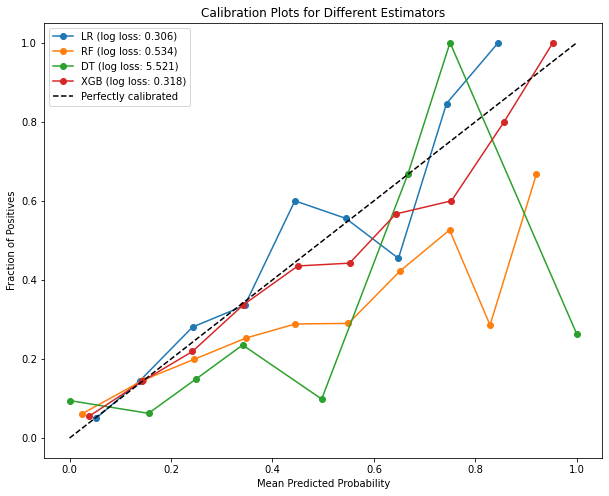

In [162]:
plt.figure(figsize=(10, 8))

for name, clf in estimators:
    # Train the classifier
    clf.fit(x_train, y_train)
    
    probs = clf.predict_proba(val_x)[:, 1]

    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, probs, n_bins=10)

    # Compute Brier score
    loss = log_loss(val_y, probs)

    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'{name} (log loss: {loss:.3f})')

# Plot the diagonal (perfectly calibrated curve)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Plots for Different Estimators')
plt.show()


### Model Hyper-parameter Tuning

In [163]:
estimators[0][1]

LogisticRegression()

In [79]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer

scoring_param = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

for name, estimator in estimators:
    scores = cross_val_score(estimator, X, y, cv=5, scoring=scoring_param)
    avg = -scores.mean()
    print("Average Cross Val Score for {} is {:.3f}".format(name, avg))

Average Cross Val Score for LR is 0.305
Average Cross Val Score for RF is 0.903
Average Cross Val Score for DT is 5.641
Average Cross Val Score for XGB is 0.321
Average Cross Val Score for SVM is 0.311


In [112]:
param_grid = {
             'rand_params':{
                 'n_estimators':[100, 200, 500, 1000],
                 'criterion':["gini", "entropy", "log_loss"]},
              'dec_params':{
                  'criterion':["gini", "entropy", "log_loss"],
                  'splitter' : ["best", "random"]}}
#names = ['svm_params', ]

In [113]:
for index, param_tuple in enumerate(param_grid.items()):
    grid_model = GridSearchCV(estimators[1:4][index][1], param_tuple[1], cv=5, scoring=scoring_param, n_jobs=-1)
    grid_model.fit(X, y)
    
    print("Best parameters: {}".format(grid_model.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_model.best_score_))

Best parameters: {'criterion': 'gini', 'n_estimators': 1000}
Best cross-validation score: -0.60
Best parameters: {'criterion': 'entropy', 'splitter': 'random'}
Best cross-validation score: -5.59
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Best cross-validation score: -0.31


### Post Calibration of all models

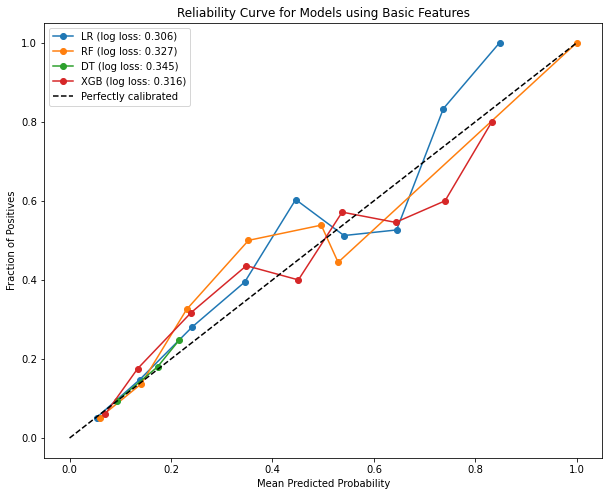

In [164]:
plt.figure(figsize=(10, 8))

for name, clf in estimators:
    # Train the classifier
    clf.fit(x_train, y_train)
    
    if name == "DT" or name == "RF":
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    else:
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='sigmoid')

    cal_model.fit(x_test, y_test)
    
    cal_prob = cal_model.predict_proba(val_x)[:,1]

    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, cal_prob, n_bins=10)

    # Compute Brier score
    loss = log_loss(val_y, cal_prob)

    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'{name} (log loss: {loss:.3f})')

# Plot the diagonal (perfectly calibrated curve)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Reliability Curve for Models using Basic Features')
plt.show()

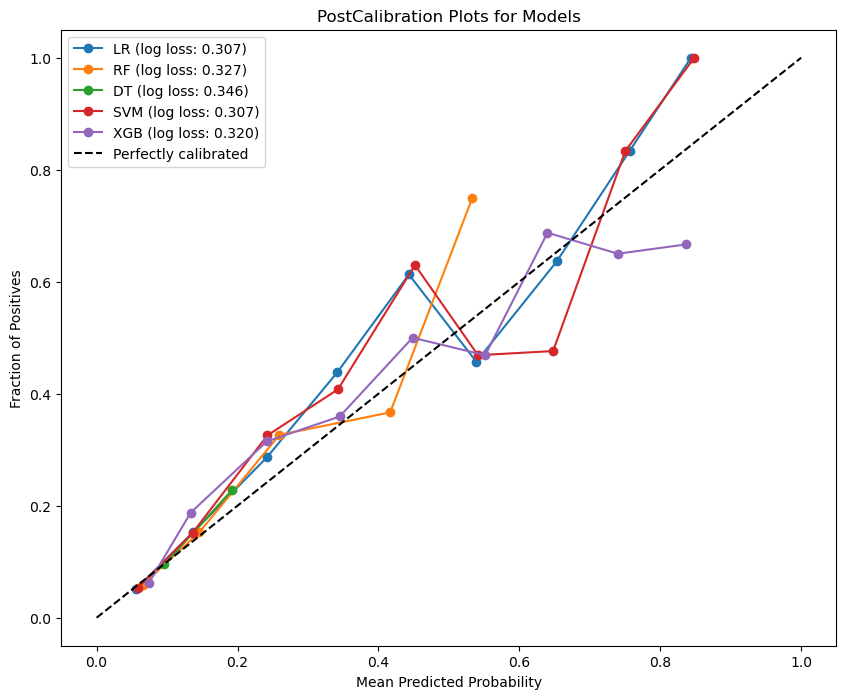

In [122]:
plt.figure(figsize=(10, 8))

for name, clf in estimators:
    # Train the classifier
    clf.fit(x_train, y_train)
    
    if name == "DT" or name =="RF":
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    else:
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='sigmoid')

    cal_model.fit(x_test, y_test)
    
    cal_prob = cal_model.predict_proba(val_x)[:,1]

    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, cal_prob, n_bins=10)

    # Compute Brier score
    loss = log_loss(val_y, cal_prob)
    
    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'{name} (log loss: {loss:.3f})')

# Plot the diagonal (perfectly calibrated curve)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('PostCalibration Plots for Models')
plt.show()

## Testing Advanced features

In [165]:
cols = ['shot_type','body_part', 'under_pressure', 'shot_technique', 'position_name', 'shot_distance','shot_angle', 'defence_density']
categorical = cols[:5]
numerical = cols[5:]
x_array, y_array, x_table = get_x_y(cluster_2_data, cols, numerical, categorical)

In [166]:
y_array = y_array.map(y_targ)

In [167]:
x_train_adv, x_test_adv, y_train_adv, y_test_adv = train_test_split(x_array, y_array, test_size=0.3, random_state=40, stratify=y_array)

In [168]:
val_data_2.reset_index(drop=True, inplace=True)

In [169]:
val_x_adv, val_y_adv, adv_data = get_x_y(val_data_2, cols, numerical, categorical)

In [170]:
val_y_adv=val_y_adv.map(y_targ)

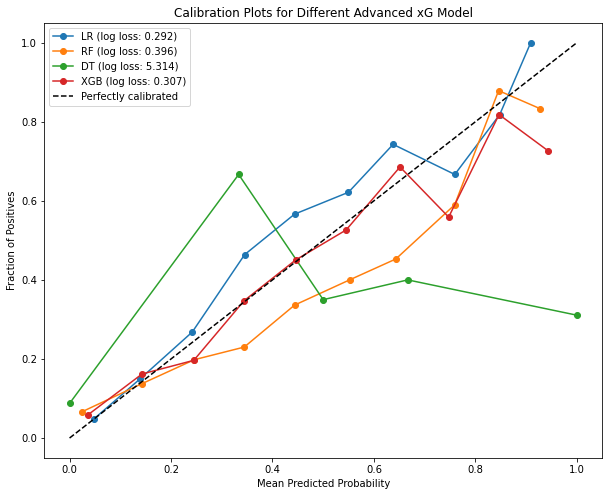

In [171]:
plt.figure(figsize=(10, 8))

for name, clf in estimators:
    # Train the classifier
    clf.fit(x_train_adv, y_train_adv)
    
    probs_adv = clf.predict_proba(val_x_adv)[:, 1]

    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y_adv, probs_adv, n_bins=10)

    # Compute Brier score
    loss = log_loss(val_y_adv, probs_adv)

    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'{name} (log loss: {loss:.3f})')

# Plot the diagonal (perfectly calibrated curve)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Plots for Different Advanced xG Model')
plt.show()


In [172]:
cluster_2_data

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defence_density,season_name,competition_name,stats_xg
0,False,No Goal,Open Play,Right Foot,Normal,midfielder,26.658770,12.341965,2.0,2017/2018,La Liga,0.008752
1,False,No Goal,Open Play,Right Foot,Normal,attacker,19.843639,18.826717,1.0,2017/2018,La Liga,0.053915
2,False,No Goal,Open Play,Left Foot,Normal,defender,15.882380,14.250033,1.0,2017/2018,La Liga,0.080842
3,False,Goal,Open Play,Right Foot,Normal,attacker,9.068627,39.394758,1.0,2017/2018,La Liga,0.456472
4,False,No Goal,Open Play,Right Foot,Normal,midfielder,28.111386,15.697815,2.0,2017/2018,La Liga,0.025283
...,...,...,...,...,...,...,...,...,...,...,...,...
18560,False,No Goal,Open Play,Right Foot,Normal,attacker,17.972479,24.389797,2.0,2019,Women's World Cup,0.117915
18561,False,No Goal,Open Play,Right Foot,Normal,midfielder,13.689412,32.023408,1.0,2019,Women's World Cup,0.074454
18562,False,No Goal,Free Kick,Right Foot,Normal,midfielder,28.563088,15.272392,3.0,2019,Women's World Cup,0.051410
18563,False,No Goal,Open Play,Right Foot,Normal,attacker,24.324884,18.658585,1.0,2019,Women's World Cup,0.054328


### Calibration of advanced Model

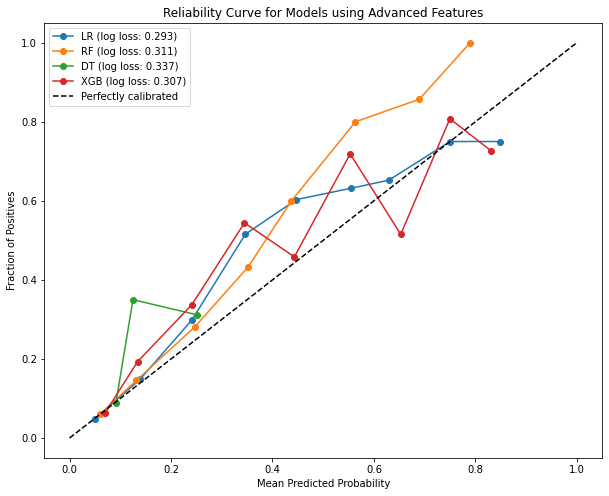

In [173]:
plt.figure(figsize=(10, 8))

for name, clf in estimators:
    # Train the classifier
    clf.fit(x_train_adv, y_train_adv)
    
    if name == "DT" or name =="RF":
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    else:
        cal_model = CalibratedClassifierCV(clf, cv='prefit', method='sigmoid')

    cal_model.fit(x_test_adv, y_test_adv)
    
    cal_prob_adv = cal_model.predict_proba(val_x_adv)[:,1]

    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y_adv, cal_prob_adv, n_bins=10)

    # Compute Log loss score
    loss = log_loss(val_y_adv, cal_prob_adv)

    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'{name} (log loss: {loss:.3f})')

# Plot the diagonal (perfectly calibrated curve)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Reliability Curve for Models using Advanced Features')
plt.show()

## Choosing Logistic Regression

In [174]:
val_data_2

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defence_density,season_name,competition_name,stats_xg
0,False,No Goal,Open Play,Left Foot,Normal,midfielder,21.284971,21.117849,4.0,2020/2021,La Liga,0.050982
1,False,No Goal,Open Play,Left Foot,Normal,attacker,14.787157,29.786272,2.0,2020/2021,La Liga,0.090202
2,False,No Goal,Open Play,Left Foot,Normal,attacker,9.284934,21.742291,1.0,2020/2021,La Liga,0.235028
3,False,No Goal,Open Play,Right Foot,Normal,defender,19.131388,15.337779,1.0,2020/2021,La Liga,0.059612
4,False,No Goal,Open Play,Left Foot,Normal,attacker,24.845321,18.260682,1.0,2020/2021,La Liga,0.054610
...,...,...,...,...,...,...,...,...,...,...,...,...
5459,False,No Goal,Open Play,Head,Normal,attacker,4.295346,80.344221,2.0,2022,FIFA World Cup,0.568312
5460,False,No Goal,Open Play,Right Foot,Normal,midfielder,23.577320,14.537291,1.0,2022,FIFA World Cup,0.028724
5461,True,No Goal,Open Play,Head,Normal,attacker,6.449806,60.255119,1.0,2022,FIFA World Cup,0.145394
5462,False,No Goal,Open Play,Right Foot,Normal,defender,26.852188,15.837147,2.0,2022,FIFA World Cup,0.028684


In [175]:
reg_model = LogisticRegression()
reg_model.fit(x_array, y_array)

model_xg = reg_model.predict_proba(val_x_adv)[:,1]

In [176]:
model_xg

array([0.02546466, 0.13115722, 0.2350194 , ..., 0.19892264, 0.02442109,
       0.02855325])

In [177]:
log_loss(val_y_adv, model_xg)

0.29267248326101597

In [224]:
pd.DataFrame.from_dict(
    {"Stats xG": val_data_2["stats_xg"],
     "LR xG": model_xg,
    "SV xG": sv_xg}).corr()

,Stats xG,LR xG,SV xG
Stats xG,1.000000,0.861936,0.853462
LR xG,0.861936,1.000000,0.995420
SV xG,0.853462,0.995420,1.000000


In [225]:
train_probs = reg_model.predict_proba(x_array)[:,1]

In [226]:
log_loss(y_array, train_probs)

0.29283717595619396

In [227]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


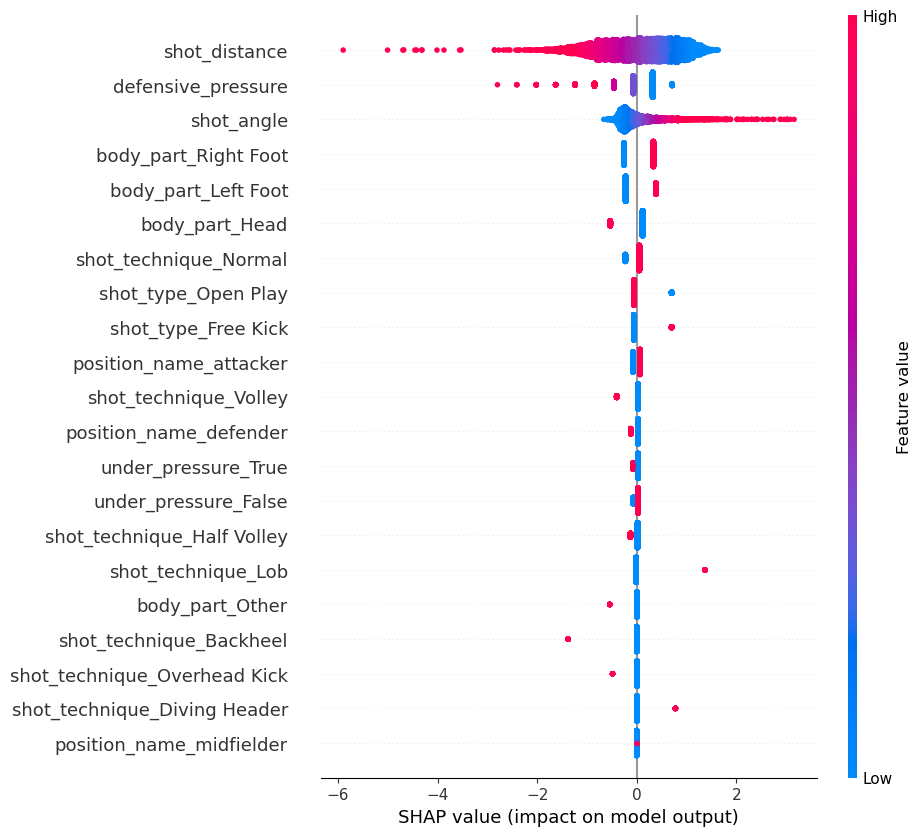

In [228]:
#import shap

# Assuming lr_model is your trained Logistic Regression model
explainer = shap.Explainer(reg_model, x_array, feature_names=adv_data.columns)
# Assuming X_test[0] is the specific instance for which you want to explain the prediction
shap_values = explainer(val_x_adv)
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values, feature_names=x_table.columns)
shap.plots.beeswarm(shap_values, max_display=23)

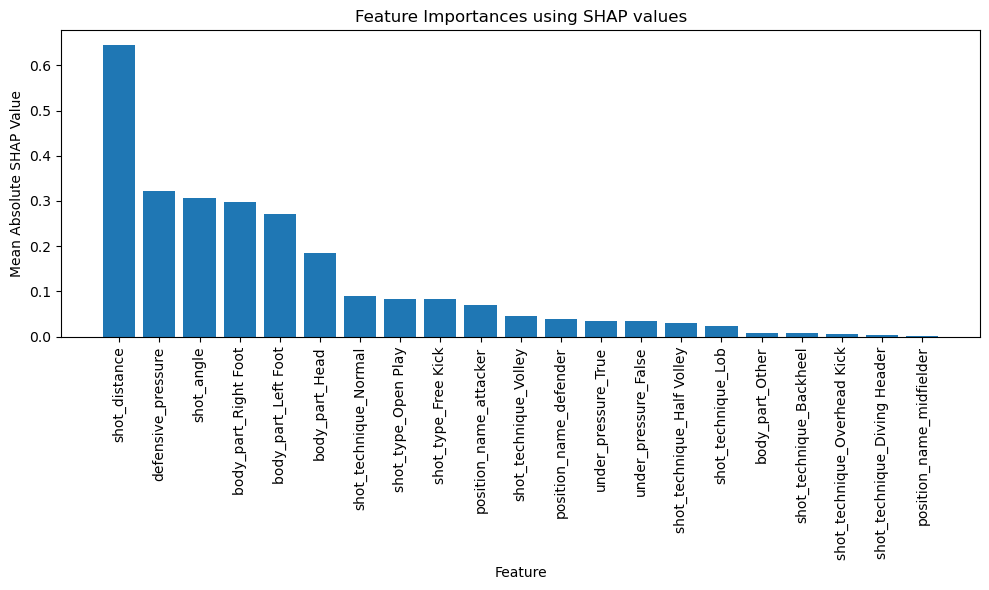

In [349]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(reg_model, x_array, feature_names=adv_data.columns)

shap_values = explainer(val_x_adv)

# Calculate the mean absolute SHAP values for each feature
mean_abs_shap = shap_values.abs.mean(axis=0)


# Sorting features by their mean absolute SHAP values
sorted_idx = mean_abs_shap.values.argsort()[::-1]

# Get the feature names for the sorted features
sorted_feature_names = [adv_data.columns[i] for i in sorted_idx]

sorted_mean_abs_shap = mean_abs_shap[sorted_idx]

# Create a bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_names)), sorted_mean_abs_shap.values)
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mean Absolute SHAP Value')
plt.title('Feature Importances using SHAP values')
plt.tight_layout()
plt.show()

In [348]:
sorted_mean_abs_shap

.values =
array([0.64497299, 0.32286297, 0.30604118, 0.29843738, 0.27192942,
       0.18474512, 0.08894521, 0.08349588, 0.08349588, 0.06993329,
       0.04487292, 0.03969384, 0.0347624 , 0.0347624 , 0.03073437,
       0.02347174, 0.00813642, 0.00756204, 0.00615138, 0.00326314,
       0.00113551])

.base_values =
-2.567802148787308

.data =
array([0.54159119, 0.82247438, 0.68128221, 0.47016837, 0.30270864,
       0.1625183 , 0.21284773, 0.03550512, 0.03550512, 0.44729136,
       0.06204246, 0.16965593, 0.20296486, 0.20296486, 0.13140556,
       0.00713763, 0.00494143, 0.00549048, 0.00256223, 0.00420937,
       0.27763543])

In [343]:
n_columns = list(adv_data.columns)

In [154]:
adv_data

,shot_type_Corner,shot_type_Free Kick,shot_type_Open Play,body_part_Head,body_part_Left Foot,body_part_Other,body_part_Right Foot,under_pressure_False,under_pressure_True,shot_technique_Backheel,...,shot_technique_Normal,shot_technique_Overhead Kick,shot_technique_Volley,position_name_v2_attacker,position_name_v2_defender,position_name_v2_goalkeeper,position_name_v2_midfielder,shot_distance,shot_angle,defensive_pressure
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,21.284971,21.117849,4.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,14.787157,29.786272,2.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,9.284934,21.742291,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,19.131388,15.337779,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,24.845321,18.260682,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.295346,80.344221,2.0
5464,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,23.577320,14.537291,1.0
5465,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6.449806,60.255119,1.0
5466,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,26.852188,15.837147,2.0


In [149]:
val_data_2[val_data_2["shot_outcome"] == "Goal"]

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defensive_pressure,season_name,competition_name,stats_xg,position_name_v2
6,False,Goal,Open Play,Head,Normal,Left Center Forward,9.235800,41.633539,1.0,2020/2021,La Liga,0.164914,attacker
8,False,Goal,Open Play,Right Foot,Normal,Left Center Forward,22.925968,19.693700,2.0,2020/2021,La Liga,0.051378,attacker
21,False,Goal,Open Play,Right Foot,Half Volley,Left Center Forward,8.683893,43.713391,1.0,2020/2021,La Liga,0.345704,attacker
29,False,Goal,Open Play,Left Foot,Normal,Center Forward,8.640023,48.546382,1.0,2020/2021,La Liga,0.440972,attacker
36,False,Goal,Open Play,Left Foot,Normal,Center Attacking Midfield,21.564091,17.317325,1.0,2020/2021,La Liga,0.056232,attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5413,False,Goal,Open Play,Left Foot,Normal,Left Wing,8.065978,41.887691,1.0,2022,FIFA World Cup,0.440301,attacker
5415,False,Goal,Open Play,Left Foot,Normal,Right Wing,14.425672,22.812316,2.0,2022,FIFA World Cup,0.096603,attacker
5429,True,Goal,Open Play,Head,Normal,Center Forward,4.998000,76.567680,1.0,2022,FIFA World Cup,0.331067,attacker
5433,False,Goal,Open Play,Left Foot,Normal,Right Wing,25.097609,14.258049,1.0,2022,FIFA World Cup,0.027778,attacker


In [222]:
val_data_2[val_data_2["shot_outcome"] == "Goal"]

,under_pressure,shot_outcome,shot_type,body_part,shot_technique,position_name,shot_distance,shot_angle,defensive_pressure,season_name,competition_name,stats_xg,position_name_v2
6,False,Goal,Open Play,Head,Normal,Left Center Forward,9.235800,41.633539,1.0,2020/2021,La Liga,0.164914,attacker
8,False,Goal,Open Play,Right Foot,Normal,Left Center Forward,22.925968,19.693700,2.0,2020/2021,La Liga,0.051378,attacker
21,False,Goal,Open Play,Right Foot,Half Volley,Left Center Forward,8.683893,43.713391,1.0,2020/2021,La Liga,0.345704,attacker
29,False,Goal,Open Play,Left Foot,Normal,Center Forward,8.640023,48.546382,1.0,2020/2021,La Liga,0.440972,attacker
36,False,Goal,Open Play,Left Foot,Normal,Center Attacking Midfield,21.564091,17.317325,1.0,2020/2021,La Liga,0.056232,attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5413,False,Goal,Open Play,Left Foot,Normal,Left Wing,8.065978,41.887691,1.0,2022,FIFA World Cup,0.440301,attacker
5415,False,Goal,Open Play,Left Foot,Normal,Right Wing,14.425672,22.812316,2.0,2022,FIFA World Cup,0.096603,attacker
5429,True,Goal,Open Play,Head,Normal,Center Forward,4.998000,76.567680,1.0,2022,FIFA World Cup,0.331067,attacker
5433,False,Goal,Open Play,Left Foot,Normal,Right Wing,25.097609,14.258049,1.0,2022,FIFA World Cup,0.027778,attacker


In [152]:
ft_data

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,play_pattern_name,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,From Throw In,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,26.658770,12.341965,2.0,101.0,21.3
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,From Free Kick,Valencia,Santiago Mina Lorenzo,Left Center Forward,Normal,19.843639,18.826717,1.0,103.9,28.4
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,From Throw In,Barcelona,Jordi Alba Ramos,Left Back,Normal,15.882380,14.250033,1.0,112.5,26.0
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,From Throw In,Barcelona,Luis Alberto Suárez Díaz,Left Center Forward,Normal,9.068627,39.394758,1.0,113.2,46.0
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Regular Play,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,28.111386,15.697815,2.0,92.8,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33364,69161,2019-06-24,72,30,"[96.3, 36.2]",False,0.038350,"[120.0, 39.1, 3.5]",No Goal,Open Play,...,From Free Kick,United States Women's,Rosemary Kathleen Lavelle,Right Center Midfield,Normal,24.002708,18.700592,3.0,96.3,36.2
33365,69161,2019-06-24,72,30,"[98.5, 24.3]",False,0.025679,"[120.0, 47.1, 1.4]",No Goal,Open Play,...,From Throw In,United States Women's,Samantha June Mewis,Left Center Midfield,Normal,26.622171,13.943962,1.0,98.5,24.3
33366,69161,2019-06-24,72,30,"[102.9, 54.6]",True,0.037896,"[120.0, 45.1, 5.2]",No Goal,Open Play,...,From Throw In,Spain Women's,Lucía García Córdoba,Right Midfield,Half Volley,22.484884,15.611898,1.0,102.9,54.6
33367,69161,2019-06-24,72,30,"[108.0, 40.0]",False,0.783500,"[120.0, 36.3, 0.2]",Goal,Penalty,...,Other,United States Women's,Megan Anna Rapinoe,Left Wing,Normal,12.000000,36.869898,NaN,108.0,40.0


## Testing on Live Results

In [230]:
ft_data

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,play_pattern_name,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,From Throw In,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,26.658770,12.341965,2.0,101.0,21.3
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,From Free Kick,Valencia,Santiago Mina Lorenzo,Left Center Forward,Normal,19.843639,18.826717,1.0,103.9,28.4
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,From Throw In,Barcelona,Jordi Alba Ramos,Left Back,Normal,15.882380,14.250033,1.0,112.5,26.0
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,From Throw In,Barcelona,Luis Alberto Suárez Díaz,Left Center Forward,Normal,9.068627,39.394758,1.0,113.2,46.0
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Regular Play,Valencia,Gonçalo Manuel Ganchinho Guedes,Left Midfield,Normal,28.111386,15.697815,2.0,92.8,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33364,69161,2019-06-24,72,30,"[96.3, 36.2]",False,0.038350,"[120.0, 39.1, 3.5]",No Goal,Open Play,...,From Free Kick,United States Women's,Rosemary Kathleen Lavelle,Right Center Midfield,Normal,24.002708,18.700592,3.0,96.3,36.2
33365,69161,2019-06-24,72,30,"[98.5, 24.3]",False,0.025679,"[120.0, 47.1, 1.4]",No Goal,Open Play,...,From Throw In,United States Women's,Samantha June Mewis,Left Center Midfield,Normal,26.622171,13.943962,1.0,98.5,24.3
33366,69161,2019-06-24,72,30,"[102.9, 54.6]",True,0.037896,"[120.0, 45.1, 5.2]",No Goal,Open Play,...,From Throw In,Spain Women's,Lucía García Córdoba,Right Midfield,Half Volley,22.484884,15.611898,1.0,102.9,54.6
33367,69161,2019-06-24,72,30,"[108.0, 40.0]",False,0.783500,"[120.0, 36.3, 0.2]",Goal,Penalty,...,Other,United States Women's,Megan Anna Rapinoe,Left Wing,Normal,12.000000,36.869898,NaN,108.0,40.0


### Team Based Results of xG prediction

#### FIFA World Cup xG

In [267]:
wc_data = ft_data[ft_data["competition_name"] == "FIFA World Cup"]
wc_data.reset_index(drop=True, inplace=True)
wc_data  = wc_data[wc_data['shot_type'].isin(['Open Play', 'Free Kick'])]
wc_data.reset_index(drop=True, inplace=True)

In [270]:
wc_data['position_name'] = wc_data['position_name'].apply(correct_lwback)
wc_data['position_name'] = wc_data['position_name'].apply(categorize_position)

In [275]:
wc_data = wc_data[wc_data['position_name'].isin(['midfielder', 'attacker', 'defender'])]
wc_data.reset_index(drop=True, inplace=True)

In [276]:
xg_wc = run_model(wc_data, reg_model)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [365]:
wc_data['Model xG Value'] = xg_wc

In [369]:
def get_xg(teams, data):
    team_xG = { 'Team Name':[],
                'Total Matches': [],
                'Total Shots': [],
                'Model xG Value': [],
                'Total Goals':[],
                'Goal to xG': []}
    for i in teams:
        curr_team = data[data["team_name"] == i].reset_index(drop=True)
        total_gls = np.sum([curr_team['shot_outcome'] == 'Goal'])
        xG = np.sum(curr_team["Model xG Value"])
        team_xG['Total Matches'].append(curr_team['match_id'].nunique())
        team_xG['Team Name'].append(i)
        team_xG['Total Shots'].append(len(curr_team))
        team_xG['Model xG Value'].append(xG)
        team_xG['Total Goals'].append(total_gls)
        team_xG['Goal to xG'].append(total_gls/xG)
    df = pd.DataFrame.from_dict(team_xG)
    return df

In [291]:
wc_teams = list(np.unique(wc_data.team_name))

In [366]:
wc_data

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Value
0,3857256,2022-12-02,43,106,"[96.0, 38.8]",False,0.036566,"[108.2, 38.5]",No Goal,Open Play,...,Switzerland,Granit Xhaka,midfielder,Half Volley,24.029981,18.879548,3.0,96.0,38.8,0.020984
1,3857256,2022-12-02,43,106,"[113.1, 40.7]",False,0.353289,"[114.8, 40.6, 1.6]",No Goal,Open Play,...,Switzerland,Breel-Donald Embolo,attacker,Half Volley,6.935416,59.821068,1.0,113.1,40.7,0.417427
2,3857256,2022-12-02,43,106,"[103.8, 41.9]",False,0.069527,"[115.5, 39.1, 1.0]",No Goal,Open Play,...,Switzerland,Granit Xhaka,midfielder,Half Volley,16.311039,27.397542,4.0,103.8,41.9,0.034482
3,3857256,2022-12-02,43,106,"[112.2, 36.8]",False,0.081609,"[120.0, 35.3, 3.5]",No Goal,Open Play,...,Serbia,Nikola Milenković,defender,Normal,8.430896,48.565404,2.0,112.2,36.8,0.094210
4,3857256,2022-12-02,43,106,"[97.8, 51.5]",False,0.030002,"[120.0, 36.1, 0.6]",No Goal,Open Play,...,Serbia,Andrija Živković,defender,Normal,25.001800,16.255762,2.0,97.8,51.5,0.034591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,7559,2018-06-25,43,3,"[102.0, 22.0]",False,0.028970,"[112.0, 36.0]",No Goal,Open Play,...,Egypt,Amr Medhat Warda,attacker,Normal,25.455844,12.835609,1.0,102.0,22.0,0.057545
3061,7559,2018-06-25,43,3,"[95.0, 30.0]",False,0.065623,"[104.0, 32.0]",No Goal,Free Kick,...,Saudi Arabia,Mohammed Al Burayk,defender,Normal,26.925824,15.753093,5.0,95.0,30.0,0.040032
3062,7559,2018-06-25,43,3,"[116.0, 30.0]",False,0.088908,"[119.0, 36.8, 0.8]",No Goal,Open Play,...,Saudi Arabia,Salem Mohammed Al Dawsari,attacker,Volley,10.770330,17.744672,0.0,116.0,30.0,0.159287
3063,7559,2018-06-25,43,3,"[101.0, 58.0]",True,0.020325,"[106.0, 52.0]",No Goal,Open Play,...,Saudi Arabia,Abdullah Ibrahim Otayf,midfielder,Normal,26.172505,12.800564,1.0,101.0,58.0,0.039377


In [370]:
wc_xg = get_xg(wc_teams, wc_data)

In [373]:
wc_data[wc_data['team_name'] == 'Argentina']

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Value
26,3869151,2022-12-03,43,106,"[98.2, 20.1]",False,0.011147,"[120.0, 47.5, 7.1]",No Goal,Open Play,...,Argentina,Alejandro Darío Gómez,attacker,Normal,29.516944,11.525564,1.0,98.2,20.1,0.039351
28,3869151,2022-12-03,43,106,"[104.2, 48.9]",False,0.066638,"[120.0, 37.1, 0.3]",Goal,Open Play,...,Argentina,Lionel Andrés Messi Cuccittini,attacker,Normal,18.134222,22.000062,1.0,104.2,48.9,0.131481
29,3869151,2022-12-03,43,106,"[99.8, 38.5]",False,0.045172,"[116.9, 40.0, 0.6]",No Goal,Open Play,...,Argentina,Lionel Andrés Messi Cuccittini,attacker,Normal,20.255617,22.286302,1.0,99.8,38.5,0.111900
30,3869151,2022-12-03,43,106,"[110.4, 50.3]",False,0.280607,"[120.0, 36.5, 0.3]",Goal,Open Play,...,Argentina,Julián Álvarez,attacker,Normal,14.080128,22.850518,0.0,110.4,50.3,0.245114
31,3869151,2022-12-03,43,106,"[95.4, 33.6]",False,0.032842,"[120.0, 31.6, 6.2]",No Goal,Open Play,...,Argentina,Lionel Andrés Messi Cuccittini,attacker,Normal,25.418891,17.344705,2.0,95.4,33.6,0.045088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,7564,2018-06-26,43,3,"[100.0, 29.0]",False,0.091842,"[120.0, 44.4, 1.1]",No Goal,Free Kick,...,Argentina,Lionel Andrés Messi Cuccittini,attacker,Normal,22.825424,17.579851,4.0,100.0,29.0,0.111792
2459,7564,2018-06-26,43,3,"[111.0, 26.0]",True,0.069989,"[111.0, 27.0]",No Goal,Open Play,...,Argentina,Ángel Fabián Di María Hernández,attacker,Normal,16.643317,15.422161,1.0,111.0,26.0,0.107413
2464,7564,2018-06-26,43,3,"[105.0, 23.0]",True,0.028244,"[114.0, 73.0]",No Goal,Open Play,...,Argentina,Nicolás Alejandro Tagliafico,defender,Normal,22.671568,13.547939,2.0,105.0,23.0,0.032818
2465,7564,2018-06-26,43,3,"[108.0, 36.0]",False,0.128031,"[120.0, 35.8, 3.6]",No Goal,Open Play,...,Argentina,Gonzalo Gerardo Higuaín,attacker,Normal,12.649111,33.690068,1.0,108.0,36.0,0.250929


In [371]:
wc_xg

,Team Name,Total Matches,Total Shots,Model xG Value,Total Goals,Goal to xG
0,Argentina,11,152,17.203747,17,0.988157
1,Australia,7,58,4.832337,3,0.620818
2,Belgium,10,142,17.690100,15,0.847932
3,Brazil,10,196,25.354865,15,0.591602
4,Cameroon,3,28,3.373825,4,1.185598
5,Canada,3,34,3.730313,1,0.268074
6,Colombia,4,41,3.285418,6,1.826251
7,Costa Rica,5,38,3.188431,3,0.940902
8,Croatia,14,191,19.075289,20,1.048477
9,Denmark,7,75,6.739349,4,0.593529


In [363]:
wc_teams

['Argentina',
 'Australia',
 'Belgium',
 'Brazil',
 'Cameroon',
 'Canada',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Denmark',
 'Ecuador',
 'Egypt',
 'England',
 'France',
 'Germany',
 'Ghana',
 'Iceland',
 'Iran',
 'Japan',
 'Mexico',
 'Morocco',
 'Netherlands',
 'Nigeria',
 'Panama',
 'Peru',
 'Poland',
 'Portugal',
 'Qatar',
 'Russia',
 'Saudi Arabia',
 'Senegal',
 'Serbia',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Tunisia',
 'United States',
 'Uruguay',
 'Wales']

#### La Liga xG Comprising Majority Barcelona Matches and Their Opponents

In [309]:
la_liga = ft_data[ft_data["competition_name"] == "La Liga"]
la_liga.reset_index(drop=True, inplace=True)
la_liga = la_liga[la_liga['shot_type'].isin(['Open Play', 'Free Kick'])]
la_liga.reset_index(drop=True, inplace=True)

In [310]:
years = ['2017/2018', '2016/2017','2010/2011',
         '2011/2012','2012/2013', '2013/2014', 
         '2014/2015','2015/2016', '2018/2019',
         '2019/2020']
la_liga_f = la_liga[la_liga["season_name"].isin(years)].reset_index(drop=True)
la_liga_f.dropna(inplace=True)
la_liga_f.reset_index(drop=True, inplace=True)

In [311]:
la_liga_f['position_name'] = la_liga_f['position_name'].apply(correct_lwback)
la_liga_f['position_name'] = la_liga_f['position_name'].apply(categorize_position)

In [255]:
#Pipeline model testing on football data.

def run_model(data, model):
    cols = ['shot_type','body_part',0 'u0nder_p0ressure', 'shot_technique', 'po0sition_name', 'shot_distance','shot_angle', 'd000efensive_pressure']
    categorical = cols[:5]
    numerical = cols[5:]
    x_array, y_array, x_table = get_x_y(data, cols, numerical, categorical)
    xG_vals = model.predict_proba(x_array)[:,1]
    return xG_vals

In [251]:
teams = la_liga_f['team_name'].unique()

In [356]:
model_xG_vals = run_model(la_liga_f, reg_model)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [357]:
la_liga_f["Model xG Value"] = model_xG_vals

In [358]:
la_liga_f

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Value
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,26.658770,12.341965,2.0,101.0,21.3,0.032836
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,Valencia,Santiago Mina Lorenzo,attacker,Normal,19.843639,18.826717,1.0,103.9,28.4,0.118409
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,Barcelona,Jordi Alba Ramos,defender,Normal,15.882380,14.250033,1.0,112.5,26.0,0.116159
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,Barcelona,Luis Alberto Suárez Díaz,attacker,Normal,9.068627,39.394758,1.0,113.2,46.0,0.408641
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,28.111386,15.697815,2.0,92.8,32.9,0.031492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8285,303473,2019-10-06,11,42,"[113.1, 36.4]",False,0.352646,"[120.0, 30.8, 0.2]",No Goal,Open Play,...,Sevilla,Javier Hernández Balcázar,attacker,Normal,7.782673,51.081639,1.0,113.1,36.4,0.523353
8286,303473,2019-10-06,11,42,"[96.8, 29.5]",False,0.034747,"[120.0, 38.7, 3.6]",No Goal,Open Play,...,Barcelona,Ivan Rakitić,midfielder,Lob,25.465467,16.353977,2.0,96.8,29.5,0.115276
8287,303473,2019-10-06,11,42,"[91.7, 48.2]",False,0.023258,"[118.1, 41.4, 0.2]",No Goal,Open Play,...,Barcelona,Lionel Andrés Messi Cuccittini,attacker,Normal,29.464046,14.879009,2.0,91.7,48.2,0.031414
8288,303473,2019-10-06,11,42,"[106.7, 33.1]",False,0.190486,"[114.1, 37.2, 0.9]",No Goal,Open Play,...,Barcelona,Luis Alberto Suárez Díaz,attacker,Half Volley,14.983324,27.035755,1.0,106.7,33.1,0.151150


In [359]:
team_xG = {
    'team name':[],
    'Total Matches': [],
    'Total Shots': [],
    'Model xG Value': [],
    'Total Goals':[],
    'Goal to xG': []}
for i in teams:
    curr_team = la_liga_f[la_liga_f["team_name"] == i].reset_index(drop=True)
    total_gls = np.sum([curr_team['shot_outcome'] == 'Goal'])
    xG = np.sum(curr_team["Model xG Value"])
    team_xG['Total Matches'].append(curr_team['match_id'].nunique())
    team_xG['team name'].append(i)
    team_xG['Total Shots'].append(len(curr_team))
    team_xG['Model xG Value'].append(xG)
    team_xG['Total Goals'].append(total_gls)
    team_xG['Goal to xG'].append(total_gls/xG)

In [353]:
len(la_liga_f)

8290

In [360]:
laligaxg = pd.DataFrame.from_dict(team_xG)
laligaxg

,team name,Total Matches,Total Shots,Model xG Value,Total Goals,Goal to xG
0,Valencia,19,180,22.856691,20,0.875017
1,Barcelona,341,5198,799.990000,850,1.062513
2,RC Deportivo La Coruña,11,115,12.939859,10,0.772806
3,Real Madrid,19,266,31.905340,22,0.689540
4,Athletic Club,17,143,18.242628,8,0.438533
5,Las Palmas,6,66,6.069168,3,0.494302
6,Eibar,11,125,12.899182,5,0.387621
7,Real Betis,15,137,15.794413,17,1.076330
8,Villarreal,16,156,16.566103,15,0.905463
9,Levante,15,134,13.622048,7,0.513873


In [ ]:
data_1[]

### Position Based Results of xG prediction

In [294]:
pos_data  = ft_data[ft_data['shot_type'].isin(['Open Play', 'Free Kick'])]
pos_data.reset_index(drop=True, inplace=True)

In [295]:
pos_data['position_name'] = pos_data['position_name'].apply(correct_lwback)
pos_data['position_name'] = pos_data['position_name'].apply(categorize_position)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [303]:
pos = pos_data[pos_data['position_name'].isin(['midfielder', 'attacker', 'defender'])]
pos.reset_index(drop=True, inplace=True)
pos.dropna(inplace=True)
pos.reset_index(drop=True, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [304]:
pos_xg = run_model(pos, reg_model)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [305]:
pos['Model xG Values'] = pos_xg


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [249]:
np.sum(la_liga_f['stats_xg'])

895.0312688457001

In [258]:
la_liga_f.columns

Index(['match_id', 'match_date', 'competition_id', 'season_id', 'location',
       'under_pressure', 'stats_xg', 'loc_end', 'shot_outcome', 'shot_type',
       'body_part', 'competition_name', 'season_name', 'play_pattern_name',
       'team_name', 'player_name', 'position_name', 'shot_technique',
       'shot_distance', 'shot_angle', 'defensive_pressure', 'x_list', 'y_list',
       'Model xG Value'],
      dtype='object')

In [306]:
la_liga_f

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Value
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,26.658770,12.341965,2.0,101.0,21.3,0.032836
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,Valencia,Santiago Mina Lorenzo,attacker,Normal,19.843639,18.826717,1.0,103.9,28.4,0.118409
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,Barcelona,Jordi Alba Ramos,defender,Normal,15.882380,14.250033,1.0,112.5,26.0,0.116159
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,Barcelona,Luis Alberto Suárez Díaz,attacker,Normal,9.068627,39.394758,1.0,113.2,46.0,0.408641
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,28.111386,15.697815,2.0,92.8,32.9,0.031492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8285,303473,2019-10-06,11,42,"[113.1, 36.4]",False,0.352646,"[120.0, 30.8, 0.2]",No Goal,Open Play,...,Sevilla,Javier Hernández Balcázar,attacker,Normal,7.782673,51.081639,1.0,113.1,36.4,0.523353
8286,303473,2019-10-06,11,42,"[96.8, 29.5]",False,0.034747,"[120.0, 38.7, 3.6]",No Goal,Open Play,...,Barcelona,Ivan Rakitić,midfielder,Lob,25.465467,16.353977,2.0,96.8,29.5,0.115276
8287,303473,2019-10-06,11,42,"[91.7, 48.2]",False,0.023258,"[118.1, 41.4, 0.2]",No Goal,Open Play,...,Barcelona,Lionel Andrés Messi Cuccittini,attacker,Normal,29.464046,14.879009,2.0,91.7,48.2,0.031414
8288,303473,2019-10-06,11,42,"[106.7, 33.1]",False,0.190486,"[114.1, 37.2, 0.9]",No Goal,Open Play,...,Barcelona,Luis Alberto Suárez Díaz,attacker,Half Volley,14.983324,27.035755,1.0,106.7,33.1,0.151150


In [328]:
pos_data = pd.concat([la_liga_f, wc_data])

In [329]:
pos_data

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,play_pattern_name,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,From Throw In,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,26.658770,12.341965,2.0,101.0,21.3
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,From Free Kick,Valencia,Santiago Mina Lorenzo,attacker,Normal,19.843639,18.826717,1.0,103.9,28.4
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,From Throw In,Barcelona,Jordi Alba Ramos,defender,Normal,15.882380,14.250033,1.0,112.5,26.0
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,From Throw In,Barcelona,Luis Alberto Suárez Díaz,attacker,Normal,9.068627,39.394758,1.0,113.2,46.0
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Regular Play,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,28.111386,15.697815,2.0,92.8,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,7559,2018-06-25,43,3,"[102.0, 22.0]",False,0.028970,"[112.0, 36.0]",No Goal,Open Play,...,From Goal Kick,Egypt,Amr Medhat Warda,attacker,Normal,25.455844,12.835609,1.0,102.0,22.0
3061,7559,2018-06-25,43,3,"[95.0, 30.0]",False,0.065623,"[104.0, 32.0]",No Goal,Free Kick,...,From Free Kick,Saudi Arabia,Mohammed Al Burayk,defender,Normal,26.925824,15.753093,5.0,95.0,30.0
3062,7559,2018-06-25,43,3,"[116.0, 30.0]",False,0.088908,"[119.0, 36.8, 0.8]",No Goal,Open Play,...,From Throw In,Saudi Arabia,Salem Mohammed Al Dawsari,attacker,Volley,10.770330,17.744672,0.0,116.0,30.0
3063,7559,2018-06-25,43,3,"[101.0, 58.0]",True,0.020325,"[106.0, 52.0]",No Goal,Open Play,...,Regular Play,Saudi Arabia,Abdullah Ibrahim Otayf,midfielder,Normal,26.172505,12.800564,1.0,101.0,58.0


In [330]:
pos_data.reset_index(drop=True, inplace=True)

In [331]:
pos_xg = run_model(pos_data, reg_model)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [332]:
pos_data['Model xG Values'] = pos_xg

In [338]:
def get_pos_xg(position):
    attacking = pos_data[pos_data['position_name'] == position]
    print(np.sum(attacking['Model xG Values']))
    print(np.sum(attacking['stats_xg']))
    print(len(attacking[attacking['shot_outcome'] == 'Goal']))
    return None

In [340]:
get_pos_xg('defender')

178.86974560754277
157.82800684469998
156


In [335]:
pos_data[pos_data['position_name'] == 'midfielder']

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Values
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,26.658770,12.341965,2.0,101.0,21.3,0.034069
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,28.111386,15.697815,2.0,92.8,32.9,0.032687
5,9880,2018-04-14,11,1,"[103.6, 36.8]",False,0.087698,"[109.8, 36.6]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,16.709279,26.495348,3.0,103.6,36.8,0.083567
7,9880,2018-04-14,11,1,"[92.0, 39.7]",False,0.017197,"[120.0, 39.0, 4.6]",No Goal,Open Play,...,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Half Volley,28.001607,16.258400,3.0,92.0,39.7,0.015112
19,9880,2018-04-14,11,1,"[97.8, 49.2]",False,0.052986,"[120.0, 35.3, 1.4]",No Goal,Open Play,...,Barcelona,Philippe Coutinho Correia,midfielder,Normal,24.030814,17.552523,1.0,97.8,49.2,0.071782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11345,7559,2018-06-25,43,3,"[96.0, 41.0]",False,0.035713,"[120.0, 42.0, 4.6]",No Goal,Open Play,...,Saudi Arabia,Hussain Al Mogahwi,midfielder,Volley,24.020824,18.893305,2.0,96.0,41.0,0.026188
11346,7559,2018-06-25,43,3,"[110.0, 49.0]",False,0.097366,"[120.0, 42.4, 0.2]",No Goal,Open Play,...,Saudi Arabia,Hussain Al Mogahwi,midfielder,Normal,13.453624,25.866357,1.0,110.0,49.0,0.071210
11348,7559,2018-06-25,43,3,"[98.0, 51.0]",False,0.040300,"[120.0, 36.2, 3.7]",No Goal,Open Play,...,Egypt,Mohamed Naser Elsayed Elneny,midfielder,Normal,24.596748,16.636753,1.0,98.0,51.0,0.066674
11349,7559,2018-06-25,43,3,"[88.0, 43.0]",False,0.030697,"[120.0, 44.2, 4.2]",No Goal,Free Kick,...,Saudi Arabia,Salman Mohammed Al Faraj,midfielder,Normal,32.140317,14.128998,5.0,88.0,43.0,0.030825


In [336]:
pos_data[pos_data['position_name'] == 'defender']

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list,Model xG Values
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,Barcelona,Jordi Alba Ramos,defender,Normal,15.882380,14.250033,1.0,112.5,26.0,0.117573
6,9880,2018-04-14,11,1,"[87.3, 53.0]",False,0.006432,"[91.5, 51.5]",No Goal,Open Play,...,Valencia,Rúben Miguel Nunes Vezo,defender,Normal,35.189345,12.080447,2.0,87.3,53.0,0.013311
15,9880,2018-04-14,11,1,"[113.9, 46.6]",True,0.069815,"[120.0, 42.2, 0.5]",Goal,Open Play,...,Barcelona,Samuel Yves Umtiti,defender,Normal,8.987213,36.995658,1.0,113.9,46.6,0.102128
16,9880,2018-04-14,11,1,"[113.6, 32.9]",True,0.064229,"[120.0, 37.1, 4.6]",No Goal,Open Play,...,Valencia,Ezequiel Marcelo Garay,defender,Normal,9.558766,34.188871,2.0,113.6,32.9,0.063169
29,9912,2018-04-29,11,1,"[113.0, 35.7]",False,0.105563,"[119.1, 41.4, 1.8]",No Goal,Open Play,...,RC Deportivo La Coruña,Raúl Albentosa Redal,defender,Normal,8.215230,47.402572,1.0,113.0,35.7,0.166160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11322,7556,2018-06-24,43,3,"[114.0, 52.0]",False,0.075421,"[120.0, 40.3, 2.3]",Goal,Open Play,...,Senegal,Moussa Wagué,defender,Normal,13.416408,16.313852,1.0,114.0,52.0,0.149609
11326,7556,2018-06-24,43,3,"[102.0, 41.0]",False,0.052775,"[105.0, 41.0]",No Goal,Open Play,...,Senegal,Salif Sané,defender,Normal,18.027756,24.986433,1.0,102.0,41.0,0.040212
11335,7559,2018-06-25,43,3,"[100.0, 22.0]",True,0.026269,"[120.0, 36.4, 4.7]",No Goal,Open Play,...,Saudi Arabia,Yasir Gharsan Al Shahrani,defender,Normal,26.907248,12.734291,1.0,100.0,22.0,0.035269
11336,7559,2018-06-25,43,3,"[95.0, 60.0]",False,0.009559,"[120.0, 45.4, 3.4]",No Goal,Open Play,...,Saudi Arabia,Mohammed Al Burayk,defender,Normal,32.015621,11.211618,1.0,95.0,60.0,0.025573


In [325]:
wc_data.drop(columns=['Model xG Values'], inplace=True)

In [327]:
la_liga_f

,match_id,match_date,competition_id,season_id,location,under_pressure,stats_xg,loc_end,shot_outcome,shot_type,...,play_pattern_name,team_name,player_name,position_name,shot_technique,shot_distance,shot_angle,defensive_pressure,x_list,y_list
0,9880,2018-04-14,11,1,"[101.0, 21.3]",False,0.008752,"[117.0, 39.7, 1.6]",No Goal,Open Play,...,From Throw In,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,26.658770,12.341965,2.0,101.0,21.3
1,9880,2018-04-14,11,1,"[103.9, 28.4]",False,0.053915,"[105.9, 29.7]",No Goal,Open Play,...,From Free Kick,Valencia,Santiago Mina Lorenzo,attacker,Normal,19.843639,18.826717,1.0,103.9,28.4
2,9880,2018-04-14,11,1,"[112.5, 26.0]",False,0.080842,"[116.6, 34.0, 0.2]",No Goal,Open Play,...,From Throw In,Barcelona,Jordi Alba Ramos,defender,Normal,15.882380,14.250033,1.0,112.5,26.0
3,9880,2018-04-14,11,1,"[113.2, 46.0]",False,0.456472,"[120.0, 43.6, 0.2]",Goal,Open Play,...,From Throw In,Barcelona,Luis Alberto Suárez Díaz,attacker,Normal,9.068627,39.394758,1.0,113.2,46.0
4,9880,2018-04-14,11,1,"[92.8, 32.9]",False,0.025283,"[117.9, 36.3, 0.5]",No Goal,Open Play,...,Regular Play,Valencia,Gonçalo Manuel Ganchinho Guedes,midfielder,Normal,28.111386,15.697815,2.0,92.8,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8285,303473,2019-10-06,11,42,"[113.1, 36.4]",False,0.352646,"[120.0, 30.8, 0.2]",No Goal,Open Play,...,From Throw In,Sevilla,Javier Hernández Balcázar,attacker,Normal,7.782673,51.081639,1.0,113.1,36.4
8286,303473,2019-10-06,11,42,"[96.8, 29.5]",False,0.034747,"[120.0, 38.7, 3.6]",No Goal,Open Play,...,Regular Play,Barcelona,Ivan Rakitić,midfielder,Lob,25.465467,16.353977,2.0,96.8,29.5
8287,303473,2019-10-06,11,42,"[91.7, 48.2]",False,0.023258,"[118.1, 41.4, 0.2]",No Goal,Open Play,...,From Keeper,Barcelona,Lionel Andrés Messi Cuccittini,attacker,Normal,29.464046,14.879009,2.0,91.7,48.2
8288,303473,2019-10-06,11,42,"[106.7, 33.1]",False,0.190486,"[114.1, 37.2, 0.9]",No Goal,Open Play,...,Regular Play,Barcelona,Luis Alberto Suárez Díaz,attacker,Half Volley,14.983324,27.035755,1.0,106.7,33.1
